In [57]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import time
import datetime
import seaborn as sns
import pandas as pd
import time
import markdown
savedate = str(datetime.datetime.now())
t = time.time()

# Setup

Bayesian update of braking force distribution

\begin{equation} E(\mu' | x) = \frac{\sigma^2 \mu + \sigma_0^2 x}{\sigma^2 + \sigma_0^2} \end{equation}

\begin{equation} Var(\mu' | x) = \frac{\sigma \sigma_0}{\sigma^2 + \sigma_0^2} \end{equation}

In [ ]:
%%time
np.random.seed(42)
tVec = []
# Train data
NWagonsFleet = 500
NWagonsTrain = 20
NMC = 100000 # Number of MC samples
M = 2000 #Trains assembled
N = 5 #Brakings observed per Train

# Wagon data 
# Mass full loaded
mass = 90000
# Brake pad friction
mu = 0.20
# Brake rigging efficiency
eta = 0.81
# Nominal pad braking force
bfNom = 4.8800000e+05
# Maximum standard deviation
sdMax = 0.1
# Resulting retardation force
rBF = bfNom*eta*mu

# Populate train fleet
fleet = {'Mass': np.random.uniform(low = .7*mass, high = mass, size = NWagonsFleet),
         'Sigma_true': np.random.uniform(low = 0.5*sdMax, high = sdMax, size = NWagonsFleet),
         'Sigma_est': 2*np.random.uniform(low = 0.5*sdMax, high = sdMax, size = NWagonsFleet),
         'n': np.zeros(NWagonsFleet)}
Fleet = pd.DataFrame(data = fleet)
Fleet['BF_true'] = rBF*np.random.normal(loc = 1, scale = Fleet['Sigma_true'])
Fleet['BF_est'] = 1.3*rBF*np.random.normal(loc = 1, scale = Fleet['Sigma_true'])
Fleet['BF_prio'] = Fleet['BF_est']
Fleet['Sigma_prio'] = Fleet['Sigma_est']
Fleet.head()
for i in range(0, M):
    t = time.time()
    # Build a train, randomly from fleet
    WagonsSelected = np.random.choice(range(0, NWagonsFleet), size =  NWagonsTrain, replace = False)
    Train = Fleet.iloc[WagonsSelected]
    # Brake N times
    for i in range(0, N):
        Train['a_obs'] = Train['BF_true'].sum()/Train['Mass'].sum()*(1+np.random.normal(0, 0.05, NWagonsTrain)) # Measurement noise
        Train['BF_obs'] = Train['a_obs']*Train['Mass']
        bfTrain = Train['BF_obs'].sum()
        # Expected behaviour, i.e. braking force distribution acc. to estimated sigma
        bfExp = pd.DataFrame(index = Train.index, 
                             data = rBF*np.random.normal(1, Train['Sigma_est'], (NMC, NWagonsTrain)).T)
        j = 0
        for wagon in Train.index:
            # Posterior: Estimate each wagon's contribution
            BFsigma = 1/rBF*(bfTrain - bfExp.loc[Train.index != wagon].sum(axis = 1)).std()
            BFsigma0 = Fleet.loc[wagon, 'Sigma_est'] # Prior sigma
            # Increment wagon usage counter
            Fleet.loc[wagon, 'n'] += 1
            # Update belief
            # Sigma
            Fleet.loc[wagon, 'Sigma_est'] = np.sqrt(BFsigma0*BFsigma/(BFsigma0**2 + BFsigma**2))
            # Mu 
            BFmu0 = Fleet.loc[wagon, 'BF_est'] # Save prior value
            BFmu = bfTrain - bfExp.loc[Train.index != wagon].sum().mean() # New mean from MC simulation
            Fleet.loc[wagon, 'BF_est'] = (BFsigma**2 * BFmu0 + BFsigma0**2 * BFmu)/(BFsigma0**2 + BFsigma**2)
        tVec.append(time.time() - t)
    
Fleet[['Sigma_true', 'Sigma_est', 'Sigma_prio']].plot()
Fleet[['n']].plot()
Fleet[['BF_true', 'BF_est', 'BF_prio']].plot()

/Users/raphael/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/raphael/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


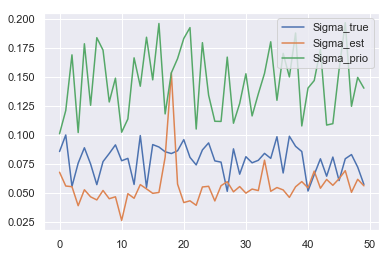

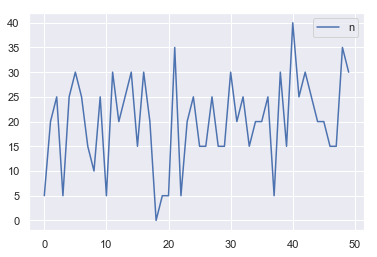

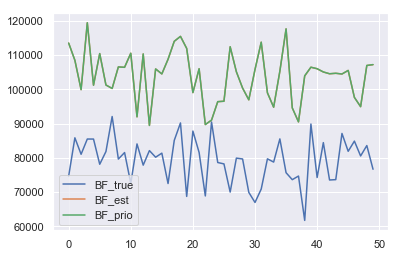

In [74]:
Fleet[['Sigma_true', 'Sigma_est', 'Sigma_prio']].plot()

Fleet[['n']].plot()
Fleet[['BF_true', 'BF_est', 'BF_prio']].plot()

In [66]:
Fleet.head()

,Mass,Sigma_est,Sigma_true,n,BF_true,BF_est,BF_prio,Sigma_prio
0,81807.169544,0.081814,0.078679,30.0,69504.655923,8.282835e+151,95570.996199,0.159916
1,81410.143634,0.080043,0.056176,25.0,72689.370461,2.684630e+127,95684.823481,0.131521
2,74997.620781,0.053406,0.068034,30.0,76106.774295,7.652012e+151,88268.818652,0.173889
3,70460.627127,0.096901,0.055608,40.0,70397.355687,8.527612e+200,103199.045488,0.113271
4,89258.611073,0.063941,0.078916,20.0,84848.744338,9.484313e+102,104322.323757,0.178756


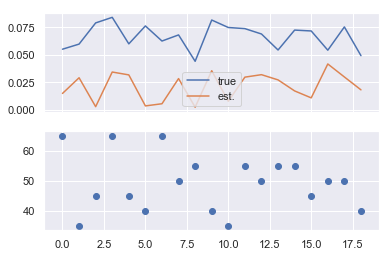

In [53]:
#Plotting
sns.set()
R = range(0,NWagonsFleet-1)
F = np.array(Fleet)
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(R, F[1:NWagonsFleet, 1], label = 'true')
axarr[0].plot(R, F[1:NWagonsFleet, 2], label = 'est.')
axarr[0].legend()
#axarr[0].set_title('Estimated vs. true SD')
axarr[1].scatter(R, F[1:NWagonsFleet, 3])

In [16]:
error = F[1:NWagonsFleet, 2] - F[1:NWagonsFleet, 1]

print('Pearson:', st.pearsonr(F[1:NWagonsFleet, 1],F[1:NWagonsFleet, 2]))
print('RMS: ', np.sqrt(np.dot(error.T, error)))


np.savetxt('TrainSim.dat', F, '%5.5f',  delimiter=' ',   newline='\n', header= 'No SDtrue Sdest n')

    # Save some data
#    aObsList.append(aObs)
#    aNomList.append(aNom)
#    sdList.append(sdTrain)
#    kList.append(kTrain)
#

Pearson: (0.99914550458599649, 0.0)
RMS:  0.859788570413


In [95]:
bfExp

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
7,97273.933042,55499.048116,129677.206313,109097.345118,70270.290132,61318.195815,109475.507925,44197.210048,27186.358916,111916.343281,...,68913.280222,43523.429945,146197.225602,100528.800539,102471.436647,145064.459045,79126.701509,116734.078667,83052.591554,145737.324946
9,79469.726241,111774.385286,45890.078719,127622.199878,62797.905527,56133.362081,55734.135200,29417.318249,32921.815356,131302.278348,...,77058.867744,12415.106156,49462.558812,85055.519787,77776.935711,105091.122921,122971.559628,13765.756398,56154.701538,64093.857222
5,171331.292390,144483.583432,55606.410771,43980.854114,-54372.530271,104558.415638,247359.608659,134320.001311,17430.854235,58663.455048,...,110920.229976,140241.233009,64575.517460,92224.267995,116687.113609,109906.412350,130296.766511,61152.655225,78908.653903,107838.496746
1,30852.139236,109247.997904,70427.809205,109165.658893,68749.718150,21625.026059,26860.650020,37587.791522,129980.930177,101764.533932,...,63642.253802,164627.048914,86069.468853,29393.675399,115923.707639,56789.983046,132566.490458,71873.863603,91301.787350,65075.308637
2,63456.591502,71838.302237,-28988.011279,125601.351024,69432.016113,96647.456386,45236.545860,23072.072173,94265.773335,147328.069922,...,8877.899289,59512.635268,59222.651248,86648.550439,59054.655355,64692.597862,101924.898135,58666.458418,22149.499973,123747.661610
4,140178.304046,86337.550904,70046.839043,129894.726240,98047.679018,64807.298129,74464.839808,39012.679258,103609.249992,10317.849067,...,47291.164455,86624.970578,140908.050884,106356.714135,112607.785273,11445.478941,89885.927132,71654.274325,134066.276131,61629.226091
3,141389.420632,-28881.416840,48880.258237,76766.856200,68556.217317,68459.059611,62648.772938,93031.297837,31180.736174,131424.333262,...,123004.929483,81183.507964,62305.754902,108679.853561,125423.839713,100755.291940,7594.935114,51219.653385,76430.534187,50286.497759
0,81480.715461,121801.216334,60667.507412,96169.716969,100504.912620,-53395.854002,74003.264987,133348.414645,60265.153741,61194.399688,...,1583.512616,152272.680176,62556.507295,79898.269200,57609.169987,84678.089509,139655.605701,64844.804484,46659.868198,25016.939806
8,76279.075853,71861.916216,50208.801851,90299.900802,107304.865490,26163.659727,40356.250165,29980.067800,105700.865705,92149.295205,...,116851.014072,60078.154279,36811.988985,67385.447429,34860.004086,97005.136262,16251.438229,127654.422694,157296.649974,131563.987628
6,98691.504896,140057.210040,-52514.337338,51558.744688,93567.543965,138405.586468,36483.500182,10306.997940,110381.613544,79916.147778,...,94063.712483,90687.107439,65794.950611,106009.907091,25362.270095,130927.771728,157364.592154,81722.886889,52702.302222,100255.935420


In [46]:
dffleet.loc[wagon, 'n'] += 1

In [60]:
(bfTrain - bfExp.loc[Train.index != wagon].sum()).std()

9109.8653251597862

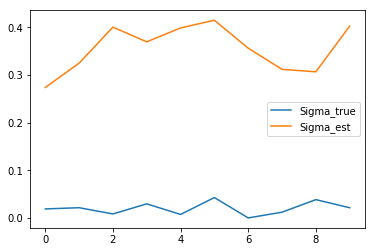

In [20]:
Fleet[['Sigma_true', 'Sigma_est']].plot()

In [102]:
Fleet

,Mass,Sigma_est,Sigma_true,n,BF_true,BF_est
0,79798.721706,2.289081e-01,0.049016,303.0,67990.073808,42326.918996
1,75821.930787,2.104356e-01,0.013680,301.0,78422.981226,40719.201802
2,88574.523134,2.036913e-01,0.010776,304.0,79194.512793,39588.835331
3,84895.743508,2.134140e-01,0.025413,301.0,78339.535647,38455.351814
4,66329.920285,2.113196e-01,0.013968,305.0,79609.001732,38777.082062
5,66622.126273,2.194808e-01,0.039509,303.0,74630.882375,38705.481205
6,88953.117007,2.186293e-01,0.011823,304.0,78978.589617,39506.539432
7,75563.510927,2.057005e-01,0.032038,300.0,82369.702085,39403.826733
8,64403.227908,2.173778e-01,0.022526,303.0,78786.729654,38924.335537
9,77715.284797,2.148755e-01,0.033600,303.0,78483.365138,40016.277901
